In [1]:
from climpyrical.gridding import scale_model_obs
from climpyrical.mask import stratify_coords
from climpyrical.data import read_data, interpolate_dataset, gen_dataset
from climpyrical.rkrig import rkrig_r
from climpyrical.cmd.find_matched_model_vals import add_model_values

from pkg_resources import resource_filename

from sklearn.neighbors import NearestNeighbors
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

### Parameters are loaded from config_example.yml
Example configuration from config_example.yml:
```
    paths:
        preprocessed_model_path: /data/results/intermediate/preprocessed_netcdf/
    RL50:
        station_dv: "RL50 (kPa)"
        station_path: 'data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv'
        input_model_path: 'data/model_inputs/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
        medians: 
            value: 0.4
            action: "multiply"
        fill_glaciers: True
```

In [2]:
# parameter cell

In [3]:
# Parameters
name = "WP10"
station_dv = "WP10 (kPa)"
station_path = "data/station_inputs/wpress_stations_rl10_rl50_for_maps.csv"
input_model_path = (
    "data/model_inputs/wpress_CanRCM4-LE_ens35_1951-2016_max_rl10_kpa_ensmean.nc"
)
medians = {"value": 0.34, "action": "multiply"}
fill_glaciers = True
output_notebook_path = "/data/results/intermediate/notebooks/"
preprocessed_model_path = "/data/results/intermediate/preprocessed_netcdf/"
preprocessed_stations_path = "/data/results/intermediate/preprocessed_stations/"
output_reconstruction_path = "/data/results/netcdf/"
output_tables_path = "/data/results/TableC2/"
output_figure_path = "/data/results/figures/"
mask_path = "data/masks/canada_mask_rp.nc"
north_mask_path = "data/masks/canada_mask_north_rp.nc"
nbcc_loc_path = "data/station_inputs/NBCC_2020_new_coords.xlsm"
nbcc_median_correction = True


Load processed moded, target canada-only mask, and the Upper Artic Area mask 

In [4]:
# Hard coded CanRCM4 upper model domain rlat
dsold_max = 28.15999984741211

ds = read_data(resource_filename("climpyrical", f"{preprocessed_model_path}{name}.nc"))
(dv, ) = ds.data_vars

mask = read_data(
    resource_filename(
        'climpyrical',
        mask_path
    ))['mask'].values

northern_mask = read_data(
    resource_filename(
        'climpyrical',
        north_mask_path
    )
)['mask'].values

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

Load processed station data

In [5]:
df = pd.read_csv(
    resource_filename(
        "climpyrical",
        f"{preprocessed_stations_path}{name}.csv"
    ), 
    index_col=False
)
df.head(3)

,irlat,irlon,WP10 (kPa),rlat,rlon,lat,lon,elev (m),station_name,province,model_values,ratio
0,558,1009,0.275,-4.286303,10.373534,42.276111,-82.955278,189.6,WINDSOR A,ON,0.297315,0.796298
1,576,1016,0.298,-3.488044,10.709117,42.999444,-82.308889,181.4,SARNIA,ON,0.306992,0.835699
2,579,1050,0.287,-3.335369,12.206823,42.850000,-80.266667,240.5,SIMCOE,ON,0.352726,0.700494


In [6]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    K = 273.15
    df[station_dv] += K
    df["model_values"] += K
    ds[dv] += K

Separate stations into beyond and within the model domain

In [7]:
df_north = df[df.rlat > dsold_max].copy()
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

Check for sets of stations that are identical. This would produce idential windows over a geographic area and disproportionately weight them in the averaged ratio field.

In [8]:
X_distances = np.stack([np.deg2rad(df_south.lat.values), np.deg2rad(df_south.lon.values)])
nbrs = NearestNeighbors(n_neighbors=30, metric="haversine").fit(
    X_distances.T
)

# Order independent window checkers
# only uses windows that are not-identical

dist, ind = nbrs.kneighbors(X_distances.T)
good_i = []
list_of_sets = []
count = 0 
for i in range(df_south.shape[0]):
    list_of_sets.append(df_south[["lon", "lat", station_dv]].iloc[ind[i]].values)
    if i+1-count == np.unique(list_of_sets, axis=0).shape[0]:
        good_i.append(i)
    else:
        warning.warn("There are identical windows!")
        count += 1 

df_south = df_south.iloc[good_i]

Calculate the station average in the UAA

In [9]:
UAA_station_mean = np.nanmean(df[station_dv][df.rlat > dsold_max-1])
UAA_station_mean

0.451

Use the best tolerance scaling to scale the model values. The ratio is already automatically scaled.

In [10]:
model_vals = df.model_values
station_vals = df[station_dv]

ratio, best_tol = scale_model_obs(df.model_values, station_vals)

# apply correction
model_vals_corrected = (model_vals/best_tol)
mean_corrected = (ds[dv].values/best_tol)

Perform ratio kriging on the set of stations below the maximum CanRCM4 native domain.

In [11]:
ratio_field = rkrig_r(df_south, 30, ds, station_dv)
ratio_field[~mask] = np.nan

  0%|          | 0/364 [00:00<?, ?it/s]

  1%|          | 2/364 [00:01<04:32,  1.33it/s]

  1%|          | 3/364 [00:03<05:53,  1.02it/s]

  1%|          | 4/364 [00:04<06:28,  1.08s/it]

  1%|▏         | 5/364 [00:05<07:06,  1.19s/it]

  2%|▏         | 6/364 [00:07<07:16,  1.22s/it]

  2%|▏         | 7/364 [00:08<07:23,  1.24s/it]

  2%|▏         | 8/364 [00:09<07:31,  1.27s/it]

  2%|▏         | 9/364 [00:11<07:41,  1.30s/it]

  3%|▎         | 10/364 [00:12<07:48,  1.32s/it]

  3%|▎         | 11/364 [00:13<08:06,  1.38s/it]

  3%|▎         | 12/364 [00:15<07:55,  1.35s/it]

  4%|▎         | 13/364 [00:16<08:02,  1.37s/it]

  4%|▍         | 14/364 [00:18<08:10,  1.40s/it]

  4%|▍         | 15/364 [00:19<08:02,  1.38s/it]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: In addition: 


R[write to console]: Warning messages:



R[write to console]: 1: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: 2: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: Timing stopped at: 0.053 0.005 0.057



  4%|▍         | 16/364 [00:19<05:58,  1.03s/it]

  5%|▍         | 17/364 [00:21<06:57,  1.20s/it]

  5%|▍         | 18/364 [00:22<07:22,  1.28s/it]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: Timing stopped at: 0.05 0 0.049



  5%|▌         | 19/364 [00:22<05:28,  1.05it/s]

  5%|▌         | 20/364 [00:24<05:45,  1.00s/it]

  6%|▌         | 21/364 [00:25<05:51,  1.02s/it]

  6%|▌         | 22/364 [00:26<05:52,  1.03s/it]

  6%|▋         | 23/364 [00:27<06:35,  1.16s/it]

  7%|▋         | 24/364 [00:28<06:22,  1.13s/it]

  7%|▋         | 25/364 [00:30<07:00,  1.24s/it]

  7%|▋         | 26/364 [00:31<07:17,  1.29s/it]

  7%|▋         | 27/364 [00:33<07:39,  1.36s/it]

  8%|▊         | 28/364 [00:34<07:56,  1.42s/it]

  8%|▊         | 29/364 [00:36<08:09,  1.46s/it]

  8%|▊         | 30/364 [00:37<08:06,  1.46s/it]

  9%|▊         | 31/364 [00:39<07:59,  1.44s/it]

  9%|▉         | 32/364 [00:40<07:51,  1.42s/it]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: Timing stopped at: 0.519 0 0.52



  9%|▉         | 33/364 [00:41<06:35,  1.19s/it]

  9%|▉         | 34/364 [00:42<07:02,  1.28s/it]

 10%|▉         | 35/364 [00:43<07:02,  1.28s/it]

 10%|▉         | 36/364 [00:45<07:12,  1.32s/it]

 10%|█         | 37/364 [00:46<07:13,  1.33s/it]

 10%|█         | 38/364 [00:47<07:12,  1.33s/it]

 11%|█         | 39/364 [00:49<07:14,  1.34s/it]

 11%|█         | 40/364 [00:50<07:23,  1.37s/it]

 11%|█▏        | 41/364 [00:51<06:59,  1.30s/it]

 12%|█▏        | 42/364 [00:53<07:13,  1.35s/it]

 12%|█▏        | 43/364 [00:54<07:23,  1.38s/it]

 12%|█▏        | 44/364 [00:56<07:06,  1.33s/it]

 12%|█▏        | 45/364 [00:57<07:05,  1.33s/it]

 13%|█▎        | 46/364 [00:58<07:11,  1.36s/it]

 13%|█▎        | 47/364 [00:59<06:53,  1.30s/it]

 13%|█▎        | 48/364 [01:01<07:10,  1.36s/it]

 13%|█▎        | 49/364 [01:02<07:06,  1.36s/it]

 14%|█▎        | 50/364 [01:04<07:07,  1.36s/it]

 14%|█▍        | 51/364 [01:05<07:14,  1.39s/it]

 14%|█▍        | 52/364 [01:07<07:39,  1.47s/it]

 15%|█▍        | 53/364 [01:08<06:39,  1.28s/it]

 15%|█▍        | 54/364 [01:09<06:33,  1.27s/it]

 15%|█▌        | 55/364 [01:10<06:00,  1.17s/it]

 15%|█▌        | 56/364 [01:11<06:34,  1.28s/it]

 16%|█▌        | 57/364 [01:13<06:29,  1.27s/it]

 16%|█▌        | 58/364 [01:14<06:44,  1.32s/it]

 16%|█▌        | 59/364 [01:15<06:39,  1.31s/it]

 16%|█▋        | 60/364 [01:17<06:40,  1.32s/it]

 17%|█▋        | 61/364 [01:18<07:22,  1.46s/it]

 17%|█▋        | 62/364 [01:20<07:13,  1.43s/it]

 17%|█▋        | 63/364 [01:21<06:53,  1.38s/it]

 18%|█▊        | 64/364 [01:22<05:39,  1.13s/it]

 18%|█▊        | 65/364 [01:22<04:48,  1.04it/s]

 18%|█▊        | 66/364 [01:23<04:09,  1.19it/s]

 18%|█▊        | 67/364 [01:23<03:44,  1.32it/s]

 19%|█▊        | 68/364 [01:25<04:43,  1.04it/s]

 19%|█▉        | 69/364 [01:26<04:42,  1.05it/s]

 19%|█▉        | 70/364 [01:27<05:07,  1.05s/it]

 20%|█▉        | 71/364 [01:28<05:48,  1.19s/it]

 20%|█▉        | 72/364 [01:30<06:13,  1.28s/it]

 20%|██        | 73/364 [01:31<06:23,  1.32s/it]

 20%|██        | 74/364 [01:32<05:50,  1.21s/it]

 21%|██        | 75/364 [01:34<05:48,  1.21s/it]

 21%|██        | 76/364 [01:35<05:47,  1.21s/it]

 21%|██        | 77/364 [01:36<05:31,  1.15s/it]

 21%|██▏       | 78/364 [01:37<05:31,  1.16s/it]

 22%|██▏       | 79/364 [01:38<05:40,  1.20s/it]

 22%|██▏       | 80/364 [01:39<04:43,  1.00it/s]

 22%|██▏       | 81/364 [01:40<04:43,  1.00s/it]

 23%|██▎       | 82/364 [01:41<05:07,  1.09s/it]

 23%|██▎       | 83/364 [01:42<05:31,  1.18s/it]

 23%|██▎       | 84/364 [01:44<05:30,  1.18s/it]

 23%|██▎       | 85/364 [01:45<05:36,  1.21s/it]

 24%|██▎       | 86/364 [01:46<05:53,  1.27s/it]

 24%|██▍       | 87/364 [01:48<05:54,  1.28s/it]

 24%|██▍       | 88/364 [01:49<05:37,  1.22s/it]

 24%|██▍       | 89/364 [01:49<04:42,  1.03s/it]

 25%|██▍       | 90/364 [01:50<04:02,  1.13it/s]

 25%|██▌       | 91/364 [01:51<04:46,  1.05s/it]

 25%|██▌       | 92/364 [01:52<04:56,  1.09s/it]

 26%|██▌       | 93/364 [01:54<05:26,  1.21s/it]

 26%|██▌       | 94/364 [01:56<06:17,  1.40s/it]

 26%|██▌       | 95/364 [01:57<06:16,  1.40s/it]

 26%|██▋       | 96/364 [01:59<06:30,  1.46s/it]

 27%|██▋       | 97/364 [02:00<06:14,  1.40s/it]

 27%|██▋       | 98/364 [02:01<05:51,  1.32s/it]

 27%|██▋       | 99/364 [02:03<06:06,  1.38s/it]

 27%|██▋       | 100/364 [02:04<06:34,  1.49s/it]

 28%|██▊       | 101/364 [02:06<06:52,  1.57s/it]

 28%|██▊       | 102/364 [02:07<06:07,  1.40s/it]

 28%|██▊       | 103/364 [02:08<05:32,  1.27s/it]

 29%|██▊       | 104/364 [02:09<05:31,  1.27s/it]

 29%|██▉       | 105/364 [02:11<05:37,  1.30s/it]

 29%|██▉       | 106/364 [02:11<04:37,  1.07s/it]

 29%|██▉       | 107/364 [02:13<04:57,  1.16s/it]

 30%|██▉       | 108/364 [02:14<05:20,  1.25s/it]

 30%|██▉       | 109/364 [02:16<05:52,  1.38s/it]

 30%|███       | 110/364 [02:17<05:44,  1.36s/it]

 30%|███       | 111/364 [02:19<06:01,  1.43s/it]

 31%|███       | 112/364 [02:19<04:51,  1.16s/it]

 31%|███       | 113/364 [02:21<05:13,  1.25s/it]

 31%|███▏      | 114/364 [02:22<05:18,  1.27s/it]

 32%|███▏      | 115/364 [02:24<05:57,  1.44s/it]

 32%|███▏      | 116/364 [02:24<04:51,  1.18s/it]

 32%|███▏      | 117/364 [02:26<05:04,  1.23s/it]

 32%|███▏      | 118/364 [02:27<04:46,  1.16s/it]

 33%|███▎      | 119/364 [02:29<05:25,  1.33s/it]

 33%|███▎      | 120/364 [02:30<05:56,  1.46s/it]

 33%|███▎      | 121/364 [02:31<04:49,  1.19s/it]

 34%|███▎      | 122/364 [02:32<04:56,  1.22s/it]

 34%|███▍      | 123/364 [02:33<04:05,  1.02s/it]

 34%|███▍      | 124/364 [02:34<04:23,  1.10s/it]

 34%|███▍      | 125/364 [02:35<04:35,  1.15s/it]

 35%|███▍      | 126/364 [02:37<05:22,  1.36s/it]

 35%|███▍      | 127/364 [02:39<05:42,  1.44s/it]

 35%|███▌      | 128/364 [02:40<05:23,  1.37s/it]

 35%|███▌      | 129/364 [02:41<05:16,  1.35s/it]

 36%|███▌      | 130/364 [02:43<05:11,  1.33s/it]

 36%|███▌      | 131/364 [02:44<05:42,  1.47s/it]

 36%|███▋      | 132/364 [02:46<05:28,  1.42s/it]

 37%|███▋      | 133/364 [02:47<05:20,  1.39s/it]

 37%|███▋      | 134/364 [02:48<05:20,  1.39s/it]

 37%|███▋      | 135/364 [02:49<05:00,  1.31s/it]

 37%|███▋      | 136/364 [02:51<05:35,  1.47s/it]

R[write to console]: Error in if (any(d < 0)) stop("distance argument must be nonnegative") : 
  missing value where TRUE/FALSE needed



R[write to console]: Timing stopped at: 0.041 0 0.041



 38%|███▊      | 137/364 [02:52<05:09,  1.36s/it]

 38%|███▊      | 138/364 [02:54<05:07,  1.36s/it]

 38%|███▊      | 139/364 [02:55<04:29,  1.20s/it]

 38%|███▊      | 140/364 [02:56<04:38,  1.24s/it]

 39%|███▊      | 141/364 [02:57<03:51,  1.04s/it]

 39%|███▉      | 142/364 [02:58<04:16,  1.16s/it]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: Timing stopped at: 0.15 0 0.15



 39%|███▉      | 143/364 [02:58<03:18,  1.11it/s]

 40%|███▉      | 144/364 [02:59<03:29,  1.05it/s]

 40%|███▉      | 145/364 [03:01<03:55,  1.07s/it]

 40%|████      | 146/364 [03:02<04:13,  1.16s/it]

 40%|████      | 147/364 [03:03<04:24,  1.22s/it]

 41%|████      | 148/364 [03:05<05:11,  1.44s/it]

 41%|████      | 149/364 [03:07<05:15,  1.47s/it]

 41%|████      | 150/364 [03:08<05:07,  1.44s/it]

 41%|████▏     | 151/364 [03:10<05:12,  1.47s/it]

 42%|████▏     | 152/364 [03:10<04:13,  1.20s/it]

 42%|████▏     | 153/364 [03:11<03:33,  1.01s/it]

 42%|████▏     | 154/364 [03:12<03:58,  1.14s/it]

 43%|████▎     | 155/364 [03:14<04:06,  1.18s/it]

 43%|████▎     | 156/364 [03:14<03:28,  1.00s/it]

 43%|████▎     | 157/364 [03:16<03:58,  1.15s/it]

 43%|████▎     | 158/364 [03:17<04:17,  1.25s/it]

 44%|████▎     | 159/364 [03:18<03:32,  1.03s/it]

 44%|████▍     | 160/364 [03:19<03:51,  1.13s/it]

 44%|████▍     | 161/364 [03:21<04:12,  1.24s/it]

 45%|████▍     | 162/364 [03:22<04:15,  1.27s/it]

 45%|████▍     | 163/364 [03:23<04:30,  1.34s/it]

 45%|████▌     | 164/364 [03:24<03:43,  1.12s/it]

 45%|████▌     | 165/364 [03:25<03:49,  1.15s/it]

 46%|████▌     | 166/364 [03:27<04:10,  1.26s/it]

 46%|████▌     | 167/364 [03:28<04:06,  1.25s/it]

 46%|████▌     | 168/364 [03:29<04:13,  1.29s/it]

 46%|████▋     | 169/364 [03:31<04:16,  1.32s/it]

 47%|████▋     | 170/364 [03:33<04:37,  1.43s/it]

 47%|████▋     | 171/364 [03:34<04:30,  1.40s/it]

 47%|████▋     | 172/364 [03:35<04:22,  1.37s/it]

 48%|████▊     | 173/364 [03:36<03:35,  1.13s/it]

 48%|████▊     | 174/364 [03:37<03:48,  1.21s/it]

 48%|████▊     | 175/364 [03:38<03:52,  1.23s/it]

 48%|████▊     | 176/364 [03:40<04:00,  1.28s/it]

 49%|████▊     | 177/364 [03:40<03:18,  1.06s/it]

 49%|████▉     | 178/364 [03:41<02:48,  1.11it/s]

 49%|████▉     | 179/364 [03:42<03:13,  1.05s/it]

 49%|████▉     | 180/364 [03:44<03:29,  1.14s/it]

 50%|████▉     | 181/364 [03:45<03:37,  1.19s/it]

 50%|█████     | 182/364 [03:46<03:50,  1.27s/it]

 50%|█████     | 183/364 [03:47<03:10,  1.05s/it]

 51%|█████     | 184/364 [03:48<03:27,  1.16s/it]

 51%|█████     | 185/364 [03:49<02:54,  1.03it/s]

 51%|█████     | 186/364 [03:50<03:07,  1.05s/it]

 51%|█████▏    | 187/364 [03:52<03:34,  1.21s/it]

 52%|█████▏    | 188/364 [03:53<03:34,  1.22s/it]

 52%|█████▏    | 189/364 [03:54<03:40,  1.26s/it]

 52%|█████▏    | 190/364 [03:56<03:39,  1.26s/it]

 52%|█████▏    | 191/364 [03:57<03:39,  1.27s/it]

 53%|█████▎    | 192/364 [03:57<03:03,  1.07s/it]

 53%|█████▎    | 193/364 [03:59<03:12,  1.13s/it]

 53%|█████▎    | 194/364 [04:00<03:18,  1.17s/it]

 54%|█████▎    | 195/364 [04:02<03:41,  1.31s/it]

 54%|█████▍    | 196/364 [04:03<03:59,  1.43s/it]

 54%|█████▍    | 197/364 [04:05<03:49,  1.37s/it]

 54%|█████▍    | 198/364 [04:06<03:43,  1.35s/it]

 55%|█████▍    | 199/364 [04:07<03:53,  1.41s/it]

 55%|█████▍    | 200/364 [04:09<03:42,  1.36s/it]

 55%|█████▌    | 201/364 [04:10<03:39,  1.34s/it]

 55%|█████▌    | 202/364 [04:12<03:51,  1.43s/it]

 56%|█████▌    | 203/364 [04:13<03:42,  1.38s/it]

 56%|█████▌    | 204/364 [04:14<03:36,  1.35s/it]

 56%|█████▋    | 205/364 [04:15<03:31,  1.33s/it]

 57%|█████▋    | 206/364 [04:16<02:54,  1.10s/it]

 57%|█████▋    | 207/364 [04:18<03:17,  1.26s/it]

 57%|█████▋    | 208/364 [04:19<03:14,  1.25s/it]

 57%|█████▋    | 209/364 [04:20<03:13,  1.25s/it]

 58%|█████▊    | 210/364 [04:21<03:18,  1.29s/it]

 58%|█████▊    | 211/364 [04:23<03:19,  1.30s/it]

 58%|█████▊    | 212/364 [04:24<03:17,  1.30s/it]

 59%|█████▊    | 213/364 [04:25<03:21,  1.33s/it]

 59%|█████▉    | 214/364 [04:27<03:23,  1.36s/it]

 59%|█████▉    | 215/364 [04:28<03:13,  1.30s/it]

 59%|█████▉    | 216/364 [04:30<03:26,  1.39s/it]

 60%|█████▉    | 217/364 [04:31<03:20,  1.37s/it]

 60%|█████▉    | 218/364 [04:32<03:18,  1.36s/it]

 60%|██████    | 219/364 [04:34<03:18,  1.37s/it]

 60%|██████    | 220/364 [04:35<03:15,  1.36s/it]

 61%|██████    | 221/364 [04:36<03:11,  1.34s/it]

 61%|██████    | 222/364 [04:38<03:07,  1.32s/it]

 61%|██████▏   | 223/364 [04:38<02:34,  1.09s/it]

 62%|██████▏   | 224/364 [04:40<02:48,  1.21s/it]

 62%|██████▏   | 225/364 [04:41<02:55,  1.27s/it]

 62%|██████▏   | 226/364 [04:42<02:59,  1.30s/it]

 62%|██████▏   | 227/364 [04:43<02:28,  1.09s/it]

 63%|██████▎   | 228/364 [04:44<02:36,  1.15s/it]

 63%|██████▎   | 229/364 [04:46<02:45,  1.23s/it]

 63%|██████▎   | 230/364 [04:46<02:16,  1.02s/it]

 63%|██████▎   | 231/364 [04:47<02:24,  1.08s/it]

 64%|██████▎   | 232/364 [04:48<02:03,  1.07it/s]

 64%|██████▍   | 233/364 [04:49<02:18,  1.06s/it]

 64%|██████▍   | 234/364 [04:50<01:57,  1.10it/s]

 65%|██████▍   | 235/364 [04:52<02:23,  1.11s/it]

 65%|██████▍   | 236/364 [04:53<02:35,  1.22s/it]

 65%|██████▌   | 237/364 [04:54<02:37,  1.24s/it]

 65%|██████▌   | 238/364 [04:56<02:36,  1.24s/it]

 66%|██████▌   | 239/364 [04:56<02:10,  1.04s/it]

 66%|██████▌   | 240/364 [04:57<02:16,  1.10s/it]

 66%|██████▌   | 241/364 [04:58<01:55,  1.07it/s]

 66%|██████▋   | 242/364 [04:59<02:15,  1.11s/it]

 67%|██████▋   | 243/364 [05:01<02:17,  1.13s/it]

 67%|██████▋   | 244/364 [05:02<02:40,  1.33s/it]

 67%|██████▋   | 245/364 [05:04<02:40,  1.34s/it]

 68%|██████▊   | 246/364 [05:05<02:43,  1.39s/it]

R[write to console]: Error in if (any(d < 0)) stop("distance argument must be nonnegative") : 
  missing value where TRUE/FALSE needed



R[write to console]: Timing stopped at: 0.058 0 0.058



 68%|██████▊   | 247/364 [05:06<02:32,  1.30s/it]

 68%|██████▊   | 248/364 [05:08<02:25,  1.26s/it]

 68%|██████▊   | 249/364 [05:08<02:06,  1.10s/it]

 69%|██████▊   | 250/364 [05:10<02:33,  1.35s/it]

 69%|██████▉   | 251/364 [05:11<02:12,  1.17s/it]

 69%|██████▉   | 252/364 [05:12<02:14,  1.20s/it]

 70%|██████▉   | 253/364 [05:14<02:16,  1.23s/it]

 70%|██████▉   | 254/364 [05:15<02:18,  1.26s/it]

 70%|███████   | 255/364 [05:16<02:20,  1.29s/it]

 70%|███████   | 256/364 [05:18<02:21,  1.31s/it]

 71%|███████   | 257/364 [05:19<02:21,  1.32s/it]

 71%|███████   | 258/364 [05:20<02:21,  1.34s/it]

 71%|███████   | 259/364 [05:21<02:14,  1.28s/it]

 71%|███████▏  | 260/364 [05:23<02:22,  1.37s/it]

 72%|███████▏  | 261/364 [05:25<02:26,  1.42s/it]

 72%|███████▏  | 262/364 [05:26<02:26,  1.44s/it]

 72%|███████▏  | 263/364 [05:27<01:59,  1.18s/it]

 73%|███████▎  | 264/364 [05:28<02:03,  1.24s/it]

 73%|███████▎  | 265/364 [05:30<02:13,  1.35s/it]

 73%|███████▎  | 266/364 [05:31<02:12,  1.36s/it]

 73%|███████▎  | 267/364 [05:33<02:20,  1.45s/it]

 74%|███████▎  | 268/364 [05:34<02:14,  1.40s/it]

 74%|███████▍  | 269/364 [05:35<02:10,  1.37s/it]

 74%|███████▍  | 270/364 [05:37<02:17,  1.46s/it]

 74%|███████▍  | 271/364 [05:38<02:11,  1.41s/it]

 75%|███████▍  | 272/364 [05:40<02:12,  1.44s/it]

 75%|███████▌  | 273/364 [05:41<02:11,  1.45s/it]

 75%|███████▌  | 274/364 [05:42<02:00,  1.34s/it]

 76%|███████▌  | 275/364 [05:44<01:57,  1.32s/it]

 76%|███████▌  | 276/364 [05:45<01:54,  1.31s/it]

 76%|███████▌  | 277/364 [05:46<01:54,  1.31s/it]

 76%|███████▋  | 278/364 [05:48<01:56,  1.36s/it]

 77%|███████▋  | 279/364 [05:49<01:54,  1.35s/it]

 77%|███████▋  | 280/364 [05:50<01:51,  1.33s/it]

 77%|███████▋  | 281/364 [05:51<01:47,  1.29s/it]

 77%|███████▋  | 282/364 [05:53<01:53,  1.39s/it]

 78%|███████▊  | 283/364 [05:55<02:04,  1.54s/it]

 78%|███████▊  | 284/364 [05:57<02:09,  1.62s/it]

 78%|███████▊  | 285/364 [05:58<02:01,  1.53s/it]

 79%|███████▊  | 286/364 [05:59<01:55,  1.48s/it]

 79%|███████▉  | 287/364 [06:01<01:51,  1.45s/it]

 79%|███████▉  | 288/364 [06:02<01:49,  1.44s/it]

 79%|███████▉  | 289/364 [06:04<01:56,  1.55s/it]

 80%|███████▉  | 290/364 [06:05<01:51,  1.50s/it]

 80%|███████▉  | 291/364 [06:07<01:45,  1.45s/it]

 80%|████████  | 292/364 [06:08<01:46,  1.48s/it]

 80%|████████  | 293/364 [06:10<01:45,  1.49s/it]

 81%|████████  | 294/364 [06:11<01:47,  1.54s/it]

 81%|████████  | 295/364 [06:13<01:44,  1.52s/it]

 81%|████████▏ | 296/364 [06:15<01:44,  1.54s/it]

 82%|████████▏ | 297/364 [06:16<01:46,  1.59s/it]

 82%|████████▏ | 298/364 [06:18<01:45,  1.60s/it]

 82%|████████▏ | 299/364 [06:19<01:38,  1.51s/it]

 82%|████████▏ | 300/364 [06:21<01:37,  1.52s/it]

 83%|████████▎ | 301/364 [06:22<01:35,  1.51s/it]

 83%|████████▎ | 302/364 [06:23<01:27,  1.41s/it]

 83%|████████▎ | 303/364 [06:25<01:27,  1.43s/it]

 84%|████████▎ | 304/364 [06:26<01:29,  1.49s/it]

 84%|████████▍ | 305/364 [06:28<01:32,  1.57s/it]

 84%|████████▍ | 306/364 [06:30<01:29,  1.54s/it]

 84%|████████▍ | 307/364 [06:31<01:22,  1.45s/it]

 85%|████████▍ | 308/364 [06:32<01:18,  1.41s/it]

 85%|████████▍ | 309/364 [06:34<01:16,  1.40s/it]

 85%|████████▌ | 310/364 [06:35<01:11,  1.32s/it]

 85%|████████▌ | 311/364 [06:36<01:08,  1.30s/it]

 86%|████████▌ | 312/364 [06:37<01:10,  1.35s/it]

 86%|████████▌ | 313/364 [06:39<01:16,  1.50s/it]

 86%|████████▋ | 314/364 [06:41<01:16,  1.53s/it]

 87%|████████▋ | 315/364 [06:42<01:13,  1.51s/it]

 87%|████████▋ | 316/364 [06:44<01:10,  1.46s/it]

 87%|████████▋ | 317/364 [06:46<01:13,  1.57s/it]

 87%|████████▋ | 318/364 [06:47<01:11,  1.54s/it]

 88%|████████▊ | 319/364 [06:48<01:08,  1.51s/it]

 88%|████████▊ | 320/364 [06:50<01:06,  1.52s/it]

 88%|████████▊ | 321/364 [06:51<01:04,  1.49s/it]

 88%|████████▊ | 322/364 [06:53<01:06,  1.58s/it]

 89%|████████▊ | 323/364 [06:55<01:07,  1.64s/it]

 89%|████████▉ | 324/364 [06:56<01:02,  1.56s/it]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: Timing stopped at: 0.397 0 0.396



 89%|████████▉ | 325/364 [06:57<00:48,  1.25s/it]

 90%|████████▉ | 326/364 [06:58<00:51,  1.36s/it]

 90%|████████▉ | 327/364 [07:00<00:53,  1.44s/it]

 90%|█████████ | 328/364 [07:02<00:53,  1.50s/it]

 90%|█████████ | 329/364 [07:03<00:53,  1.52s/it]

 91%|█████████ | 330/364 [07:06<00:58,  1.73s/it]

 91%|█████████ | 331/364 [07:07<00:53,  1.61s/it]

 91%|█████████ | 332/364 [07:09<00:53,  1.67s/it]

 91%|█████████▏| 333/364 [07:11<00:54,  1.77s/it]

 92%|█████████▏| 334/364 [07:12<00:52,  1.76s/it]

 92%|█████████▏| 335/364 [07:14<00:46,  1.60s/it]

 92%|█████████▏| 336/364 [07:16<00:47,  1.71s/it]

 93%|█████████▎| 337/364 [07:17<00:42,  1.58s/it]

 93%|█████████▎| 338/364 [07:20<00:50,  1.94s/it]

 93%|█████████▎| 339/364 [07:21<00:46,  1.88s/it]

 93%|█████████▎| 340/364 [07:23<00:44,  1.84s/it]

 94%|█████████▎| 341/364 [07:25<00:42,  1.84s/it]

 94%|█████████▍| 342/364 [07:27<00:40,  1.82s/it]

 94%|█████████▍| 343/364 [07:28<00:34,  1.66s/it]

 95%|█████████▍| 344/364 [07:30<00:34,  1.70s/it]

 95%|█████████▍| 345/364 [07:32<00:32,  1.72s/it]

 95%|█████████▌| 346/364 [07:33<00:27,  1.53s/it]

 95%|█████████▌| 347/364 [07:35<00:31,  1.87s/it]

 96%|█████████▌| 348/364 [07:37<00:26,  1.68s/it]

 96%|█████████▌| 349/364 [07:39<00:29,  1.96s/it]

 96%|█████████▌| 350/364 [07:41<00:26,  1.87s/it]

 96%|█████████▋| 351/364 [07:43<00:24,  1.87s/it]

 97%|█████████▋| 352/364 [07:45<00:22,  1.88s/it]

 97%|█████████▋| 353/364 [07:47<00:22,  2.08s/it]

 97%|█████████▋| 354/364 [07:50<00:21,  2.14s/it]

 98%|█████████▊| 355/364 [07:52<00:19,  2.12s/it]

 98%|█████████▊| 356/364 [07:54<00:17,  2.16s/it]

 98%|█████████▊| 357/364 [07:56<00:14,  2.12s/it]

 98%|█████████▊| 358/364 [07:58<00:12,  2.06s/it]

 99%|█████████▊| 359/364 [08:01<00:11,  2.29s/it]

 99%|█████████▉| 360/364 [08:03<00:09,  2.34s/it]

 99%|█████████▉| 361/364 [08:06<00:07,  2.47s/it]

 99%|█████████▉| 362/364 [08:08<00:04,  2.44s/it]

100%|█████████▉| 363/364 [08:11<00:02,  2.42s/it]

100%|██████████| 364/364 [08:13<00:00,  2.49s/it]

100%|██████████| 364/364 [08:15<00:00,  1.36s/it]

Select the UAA strip to sample the reconstruction values from.

In [12]:
selection = ~np.isnan(ds[dv].where((ds.lat > 72.) & (ds.lat < 73) & (ds.lon - 360 < -75) & (ds.lon - 360 > -127)))

Fill and reconstruct the ratio field.

In [13]:
nanmask = ~np.isnan(ratio_field)

points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_points = np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T

# We treat TJul2.5 and TwJul2.5 slightly differently than the other DVs
# since an artefact appears in SW Yukon in the CanRCM4 models. Since
# stations happen to be close to coastlines for this DV, we directly
# fill with the nearest reconstructed value, as opposed to the ratio value for 
# the remaining DVs
if station_dv == "TJul2.5 (degC)" or station_dv == "TwJul2.5 (degC)":
    reconstructed_field = ratio_field*mean_corrected.copy()
    target_values = reconstructed_field[nanmask]
    reconstructed_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
else:
    target_values = ratio_field[nanmask]
    ratio_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
    reconstructed_field = ratio_field*mean_corrected.copy()

reconstructed_field_strip_mean = np.nanmean(reconstructed_field[selection])
combined_ratio_station_mean = np.mean([reconstructed_field_strip_mean, UAA_station_mean])
reconstructed_field[northern_mask] = combined_ratio_station_mean

Compare kriged ratio values at station grids, with the original ratio values at station krids

<AxesSubplot:title={'center':'WP10 Distributions of Results'}, xlabel='Ratios at Station Grid Cells (i)'>

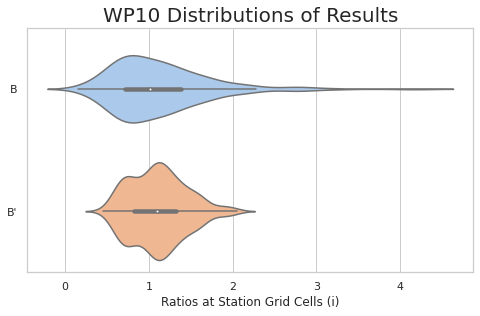

In [14]:
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 4.5))

violindata = np.concatenate([df.ratio, ratio_field[df.irlat, df.irlon]])

b_str = ["B" for x in df.ratio.values]
bp_str = ["B'" for x in ratio_field[df.irlat, df.irlon]]

vstrings = np.concatenate([b_str, bp_str])
vdf = pd.DataFrame({"Ratios at Station Grid Cells (i)": violindata, '': vstrings})

ax.set_title(f"{name} Distributions of Results", fontsize=20)
sns.violinplot(ax=ax, x="Ratios at Station Grid Cells (i)", y='', data=vdf, palette=sns.color_palette('pastel'))

Summarize reconstruction stats

In [15]:
print(
    "Northern fill value:"
    "\n"
    "Reconstruction", reconstructed_field_strip_mean,
    "\n"
    "UAA_station_mean", UAA_station_mean,
    "\n"
    "Combined", combined_ratio_station_mean
)

Northern fill value:
Reconstruction 0.3715157627818693 
UAA_station_mean 0.451 
Combined 0.41125788139093467


Convert back to degC if K was used in previous steps. Generate dataset.

In [16]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    print("Convert back to degC")
    K = 273.15 # K
    reconstructed_field -= K
    df[station_dv] -= K
#     ds[dv].attrs["units"] = "degC"

ds_recon = gen_dataset(dv, reconstructed_field, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

# Load in NBCC Tables for Comparisons

In [17]:
nrc_path = resource_filename("climpyrical", nbcc_loc_path)
df_nrc = pd.read_excel(nrc_path).iloc[:-1]

# fill problem values with better values from 2015
id_typo = df_nrc[(df_nrc['2020 Longitude'] > 0) | (df_nrc['2020 Latitude'] < 40)].index
df_nrc.loc[id_typo, '2020 Longitude'] = df_nrc['2015 Long.'].values[id_typo]
df_nrc.loc[id_typo, '2020 Latitude'] = df_nrc['2015 Lat.'].values[id_typo]

# process to get the model values
df_nrc.rename(columns={"2020 Longitude": "lon",
                      "2020 Latitude": "lat"})

df_nrc_matched = pd.DataFrame(
    {
     'Location': df_nrc.Location, 
     'Prov': df_nrc.Prov,
     "2020 Elev (m)": df_nrc["2020 Elev (m)"],
     'lon': df_nrc['2020 Longitude'], 
     'lat': df_nrc['2020 Latitude']
     }
    
)

__This step aims to correct the final field to the NBCC 2015 results.__

This is configurable by setting `nbcc_median_correction` to True or False.

1) Find the median of these values. Compute the difference, d = median(R) - median(NRC), and ratio, f = median(R)/median(NRC) 

2) For the non-temperature DVs and HDD, apply the multiplicative correction (1/f)*R_j over the entire reconstruction grid. For the temperature DVs, apply the correction as R_j - d

In [18]:
value = medians["value"]
action = medians["action"]

if action != "add" and action != "multiply" and action != "None":
    raise ValueError("Please provide either add or multiply or None actions in config.")

    
dfp = add_model_values(ds=ds_recon, df=df_nrc_matched)
reconstructed_field_med = ds_recon[dv].values

if nbcc_median_correction:
    if value != "None" or action != "None":
#         med_pcic = np.nanmedian(dfp["model_values"])
        med_pcic = np.nanmean(dfp["model_values"])

        if action == "multiply":
            fr = med_pcic/value
            reconstructed_field_med = (1/fr)*reconstructed_field_med
            print("f:", fr)
        if action == "add":
            d = med_pcic - value
            reconstructed_field_med = reconstructed_field_med - d
            print("d:", d)

INFO:root:Detect units: kPa


INFO:root:rlat or rlon not detected in input file.converting assumes WGS84 coords to rotated pole


INFO:root:Matching coordinates now


INFO:root:Locating corresponding model valuesInterpolating to nearest if matched model value is NaN


f: 0.7363528922835313


Re-create dataset if median correction applied

In [19]:
ds_recon = gen_dataset(dv, reconstructed_field_med, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

Populate with headers from the input processed model.

In [20]:
if ds.attrs:
    all_keys = set(ds_recon.variables).union(set(ds_recon.dims))
    for key in all_keys:
        ds_recon[key].attrs = ds[key].attrs
    attr_dict = ds.attrs
    attr_dict["Climpyrical"] = (
        "CanRCM4 Reconstruction contains"
        "hybrid station and model data using"
        "Climpyrical (https://github.com/pacificclimate/climpyrical)"
    )

    ds_recon.attrs = attr_dict
else:
    raise warnings.warn("No attributes detected in dataset file")

In [21]:
ds_recon.to_netcdf(
    resource_filename(
        "climpyrical",
        f"{output_reconstruction_path}{name}_reconstruction.nc"
    ),
    mode="w"
)